# Altitude Data Engineering
Geo vis group - predicting sea level rise

Overview:

- **get_gdal** Given a latitude / longitude (gps) coordinate pair, download the corresponding GDAL image of the geography.
    - if needed, make multiple smaller requests in order to download entire dataset, and combine them into one
- **map_altitudes** Given a GDAL image and X altitude ranges (eg: 0 - 10 meters, 10 - 20 meters, etc.), output polygon shape coordinates on the map for the given altitude ranges.
    - keep GPS coordinates in final polygon dataset
    - Idea: Multipass sparse matrix with convolutions
- **combine_polygons** Given two polygons and their gps coordinates, combine them into a single shape with gps coordinates loadable into mapbox. 



In [102]:
#example to download packages
#import sys
#!{sys.executable} -m pip install elevation

In [4]:
from osgeo import gdal
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import elevation 

In [103]:
#create our dataset

#hawaii big island data
#bl = [-156.09,18.00] #bottom left lon /lat
#tr = [-154.81,21.00] #top right lon /lat

#elevation.clip(bounds=(bl[0], bl[1], tr[0], tr[1]), output='data/locations/hawaii_big_island.tif')
#elevation.clean()

#See: https://github.com/bopen/elevation
#or run: 
#eio clip -o Hawaii.tif --bounds -156.09 19.00 -154.81 20.26

#the format is: 
#eio clip -o Hawaii.tif --bounds long1 lat1 long2 lat2
# Below we have long1 -156.70 and lat1 20.78
!eio clip -o Maui.tif --bounds -159.78 20.624139 -156.33 22.22


Traceback (most recent call last):
  File "/usr/local/bin/eio", line 8, in <module>
    sys.exit(eio())
  File "/usr/local/lib/python3.8/site-packages/click/core.py", line 722, in __call__
    return self.main(*args, **kwargs)
  File "/usr/local/lib/python3.8/site-packages/click/core.py", line 697, in main
    rv = self.invoke(ctx)
  File "/usr/local/lib/python3.8/site-packages/click/core.py", line 1066, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/usr/local/lib/python3.8/site-packages/click/core.py", line 895, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/usr/local/lib/python3.8/site-packages/click/core.py", line 535, in invoke
    return callback(*args, **kwargs)
  File "/usr/local/lib/python3.8/site-packages/click/decorators.py", line 17, in new_func
    return f(get_current_context(), *args, **kwargs)
  File "/usr/local/lib/python3.8/site-packages/elevation/cli.py", line 59, in wrapper
    return wrapped(**kwargs)
  File "/u

In [64]:
#TODO, create custom rects for each of these 
#elevations
#export these as datasets (geocoordinates)
levels = list(range(0, 80, 10))

#from coordinates (bottom-left --> top-right) -156.09 19.00 -154.81 20.26
filename = "data/Hawaii.tif"
gdal_data = gdal.Open(filename)
gdal_band = gdal_data.GetRasterBand(1)
nodataval = gdal_band.GetNoDataValue()

# convert to a numpy array
data_array = gdal_data.ReadAsArray().astype(np.float)

# replace missing values if necessary
if np.any(data_array == nodataval):
    data_array[data_array == nodataval] = np.nan

print(data_array.shape)

#save to csv
#np.savetxt("data/locations/hawaii_big_island.csv", data_array, delimiter=",")


sliced = []
for x in range(0,data_array.shape[0],100):
    sliced_x = []
    for y in range(0,data_array.shape[1],100):
        #print(data_array[x][y])
        sliced_x.append(data_array[x][y])
    sliced.append(sliced_x)

[0, 10, 20, 30, 40, 50, 60, 70]
(4536, 4608)


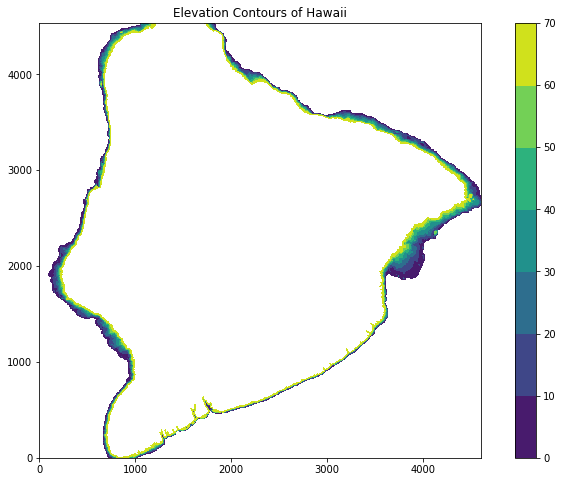

In [81]:
#Plot our data with Matplotlib's 'contourf'
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.contourf(data_array, cmap = "viridis", 
            levels = levels)
plt.title("Elevation Contours of Hawaii")
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [48]:
def translate(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)



def toGEO(i,j, bottom_left, top_right):
    """ given an i,j index, will return (lon,lat,elevation)"""
    ele = data_array[i][j]
    lon = translate(i, 0, data_array.shape[0], bottom_left[0], top_right[0])
    lat = translate(j, 0, data_array.shape[1], bottom_left[1], top_right[1])
    return (lon,lat,ele)



In [83]:
#create a dataset for each level
#from coordinates (bottom-left --> top-right) -156.09 19.00 -154.81 20.26

level_coords = {}
level_xy = {}
for l in levels:
    level_coords[l] = []
    level_xy[l] = []


    
    
min_val = min(levels)
max_val = max(levels)

ten_meters = []
ten_meters_poly_x = []
ten_meters_poly_y = []
for i,x in enumerate(data_array):
    for j,y in enumerate(x):
        z = data_array[i][j]
        if z < min_val or z > max_val:
            #ignore data outside of our range
            continue
        #ok, now assign this point to a level
        last_level = 0
        for l in levels:
            if z < l:
                vals = toGEO(i,j,bl,tr)
                #TODO: just add lon / lat
                level_xy[last_level].append((j,i))
                level_coords[last_level].append((vals[0],vals[1]))
                #ten_meters_poly_x.append(j)
                #ten_meters_poly_y.append(i)
                break
            last_level = l
            


In [98]:
#Create a set of polygons
polys = []
ten_meters = level_xy[0]
buffer_x = []
buffer_y = []
buffer_max = 1000

for c in ten_meters:
    buffer_x.append(c[0])
    buffer_y.append(c[1])
    if len(buffer_x) == buffer_max:
        min_x = min(buffer_x)
        max_x = max(buffer_x)
        min_y = min(buffer_y)
        max_y = max(buffer_y)
        
        #add this shape to polys
        shape = [(min_x,min_y),(min_x,max_y), (max_x, min_y), (max_x, max_y)]
        polys.append(shape)
        
        #reset our buffers
        buffer_x = []
        buffer_y = []
        
#Check for final val in buffers
if len(buffer_x) > 0:
    min_x = min(buffer_x)
    max_x = max(buffer_x)
    min_y = min(buffer_y)
    max_y = max(buffer_y)
    shape = [(min_x,min_y),(min_x,max_y), (max_x, min_y),(max_x, max_y)]
    polys.append(shape)


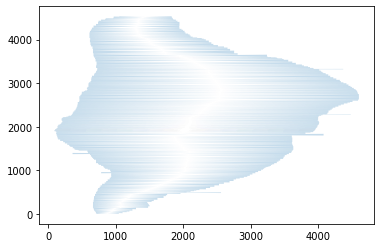

In [99]:
#PLOT SHAPE USING POLYGONS
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon


patches = []
colors = []
#example = [[[0,1],[0,2],[2,2]], [[1,1],[1,2],[3,2]] ]

for s in polys:
    patches.append(Polygon(s))

fig, ax = plt.subplots()
p = PatchCollection(patches, alpha=0.25)
ax.add_collection(p)
ax.autoscale()
plt.show()

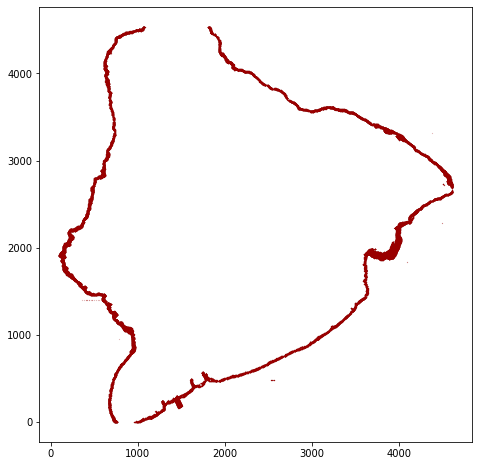

In [101]:
#PLOT ALL POINTS BY LEVEL
colors = [
    "#ffffd9",
    "#edf8b1",
    "#c7e9b4",
    "#7fcdbb",
    "#41b6c4",
    "#1d91c0",
    "#225ea8",
    "#0c2c84",
]
colors2 = [
"#fff7ec",
"#fee8c8",
"#fdd49e",
"#fdbb84",
"#fc8d59",
"#ef6548",
"#d7301f",
"#990000",
]
colors.reverse()
colors2.reverse()

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)

for i,l in enumerate(levels):
    if i > 0:
        break
    data_x = [x[0] for x in level_xy[l]]
    data_y = [x[1] for x in level_xy[l]]
    plt.scatter(data_x,data_y, s=0.01, c=colors2[i])
plt.gca().set_aspect('equal', adjustable='box')

plt.show()
